In [2]:
import numpy as np
import pandas as pd
import os
import natsort as ns
import matplotlib.pyplot as plt

#### this is not the right file ####

In [3]:
path = '/Users/georgienahass/Desktop/alkureishiLab/thermal_camera/thermalData_expeirment_1'

file_list = []

for root, dirs,files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            path =(os.path.join(root, file))
            file_list.append(path)

file_list = ns.natsorted(file_list)

In [15]:
dfs = []
mean = []
maximum = []
indices = []
x_axis = []
interestingDfs = []
threshold = 35

for idx, file in enumerate(file_list):
    try:
        df = pd.read_csv(file, skiprows = 3, header=None) 
        fake_column_names = [f"col{i}" for i in range(0, len(df.columns))]
        max_index = df.stack().idxmax()
        indices.append(max_index)
        max_val = df.max().max()
        mean_val = df.mean().mean()
        
        if (df>threshold).any().any():
            interestingDfs.append(df)
            
        maximum.append(max_val)
        mean.append(mean_val)
        x_axis.append(idx+1)
        # df = df.rename(columns={'Height': 'Unnamed: 0', '240': 'Unnamed: 1'})
        dfs.append(df)
    except pd.errors.EmptyDataError:
        pass

 

In [16]:

"""
Get index of all cells that go above a certain temperature threshold  
We will then use these indices to plot the value of the important cells over the course of the experient    
  
"""
threshold_indices = []
for df in interestingDfs:
    idx = np.where(df.values > threshold)
    pairs = list(zip(idx[0], idx[1]))
    threshold_indices.append(pairs)
flat_list = [item for sublist in threshold_indices for item in sublist]
unique_indices = list(set(flat_list))

cellsAboveThresh = []
for i,j in unique_indices:
    temp = []
    for df in dfs:
        temp.append(df.iloc[i, j])
    cellsAboveThresh.append(temp)


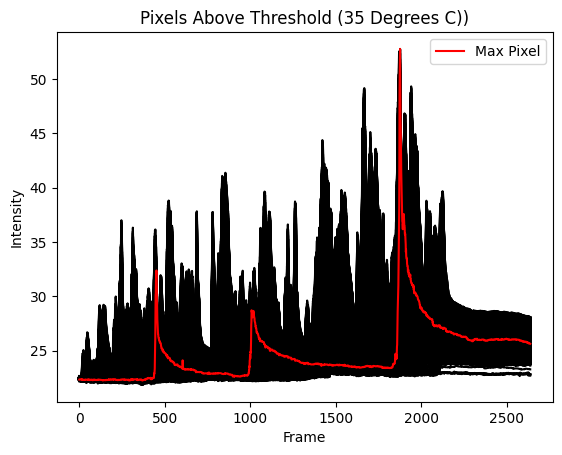

In [17]:
maxValIndex= np.argmax(maximum)
maxCellVals = [dfs[idx].loc[indices[maxValIndex]] for idx, df in enumerate(dfs)]

fig, ax = plt.subplots()

for lst in cellsAboveThresh:
    ax.plot(x_axis, lst, color = 'black')

ax.plot(x_axis, maxCellVals, color='red', label = 'Max Pixel')


ax.set_xlabel('Frame')
ax.set_ylabel('Intensity')
ax.set_title('Pixels Above Threshold (35 Degrees C))')
ax.legend()

plt.show()





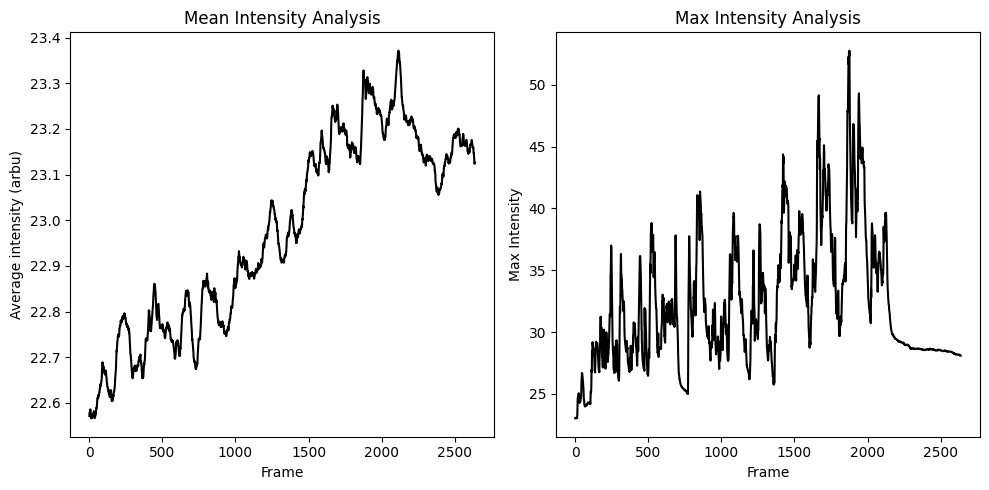

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

# Plot data on the first subplot
ax1.plot(x_axis, mean, color='black')
ax1.set_ylabel('Average intensity (arbu)')
ax1.set_xlabel('Frame')
ax1.set_title("Mean Intensity Analysis")
# ax1.set_ylim([0, 500])


# Plot data on the second subplot
ax2.plot(x_axis, maximum, color='black')
ax2.set_title("Max Intensity Analysis")
ax2.set_ylabel('Max Intensity')
ax2.set_xlabel('Frame')
# ax2.set_ylim([0, 500])

plt.tight_layout()

plt.show() 

In [ ]:
len(dfs)

297

In [ ]:
t1 = pd.concat(dfs[0:60], axis=0)
t1_mean = t1.groupby('col320').mean()

t2 = pd.concat(dfs[60:120], axis=0)
t2_mean = t2.groupby('col320').mean()

t3 = pd.concat(dfs[120:180], axis=0)
t3_mean = t3.groupby('col320').mean()

t4 = pd.concat(dfs[180:240], axis=0)
t4_mean = t4.groupby('col320').mean()

t5 = pd.concat(dfs[240:298], axis=0)
t5_mean = t5.groupby('col320').mean()

mean_data = [t1_mean, t2_mean, t3_mean, t4_mean, t5_mean]


In [ ]:
df_concat = pd.concat(mean_data, axis=0)

# add a 'timepoint' column to the concatenated DataFrame
df_concat['timepoint'] = np.repeat(np.arange(len(mean_data)), df_concat.shape[0] / len(mean_data))

# group the concatenated DataFrame by 'timepoint'
groups = df_concat.groupby('timepoint')

# extract the pixel values from each group and stack them into a 3D array
arrays = [g.iloc[:, :-1].to_numpy() for _, g in groups]  # ignore the 'timepoint' column in each group
stacked_data = np.stack(arrays)

# print the shape of the stacked data matrix
print(stacked_data.shape)

(5, 240, 320)


In [ ]:
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch


# Compute pairwise distances between data points using Euclidean distance
def cluster(data):
    distances = pdist(data.values, metric='euclidean')

    # Perform hierarchical clustering using complete linkage
    z = sch.linkage(distances, method='complete')

    return z

# t1 = cluster(t1_mean)
# t2 = cluster(t2_mean)
# t3 = cluster(t3_mean)
t4 = cluster (t4_mean)
# t5 = cluster (t5_mean)
# Plot the resulting dendrogram
# sch.dendrogram(t1)
# plt.show()

sch.dendrogram(t4)
plt.show()



#Reorder the rows and columns of the data based on the dendrogram
idx = sch.leaves_list(t4)
df = df.iloc[idx, :]
df = df.iloc[:, idx]

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(df, cmap='viridis')
plt.colorbar(cax)
plt.show()
# Show the plot


In [ ]:
plt.figure(figsize = (12,9))
plt.scatter(dfs[0], dfs[0]['col320'])
plt.show

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def kmeans(frame):
    # Flatten each matrix into a one-dimensional array
    data = np.array([np.ravel(frame.iloc[i,:]) for i in range(len(frame))])
    # Normalize the data us
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    ## Z score normalization (mean is 0, STdev is 1)
    # data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    ## MIN MAX NORMALIZATION 
    # data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))
    print(data)
    # Use k-means clustering to identify clusters
    kmeans = KMeans(n_clusters=2, random_state=0).fit(data)
    labels = kmeans.labels_
    return data, labels




In [ ]:
# Visualize the results of the clustering
t1, t1l = kmeans(t1_mean)
t2, t2l = kmeans(t2_mean)
t3, t3l = kmeans(t3_mean)
t4, t4l = kmeans(t4_mean)
t5, t5l = kmeans(t5_mean)


plt.scatter(t1[:,0], t1[:,1], c=t1l)
plt.show()

plt.scatter(t3[:,0], t3[:,1], c=t3l)
plt.show()
plt.scatter(t4[:,0], t4[:,1], c=t4l)
plt.show()
plt.scatter(t5[:,0], t5[:,1], c=t5l)
plt.show()